# Computing velocities through lines parallel to the cut

## Load data and modules

In [898]:
# Load modules
import tqdm
import czifile
import tifffile
import sys
import os
import io
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pathlib

from PIL import Image
from IPython.display import Image as IPImage, display
from matplotlib.animation import FuncAnimation
from skimage.io import imread
from itertools import combinations

import cv2


In [899]:
# Convert images to tiff
src_folder = '../../data/ablation-czi'
new_folder = '../../data/tiff'

# Create new folder
os.makedirs(new_folder, exist_ok=True)

# Check if destination folder already has files
if len(os.listdir(new_folder)) > 0:
    print(f"Folder {new_folder} already has files — skipping conversion.")
else:
    # Convert all .czi files
    for file in tqdm.tqdm(os.listdir(src_folder), desc="Converting CZI to TIFF"):
        if file.endswith('.czi'):
            czi_path = os.path.join(src_folder, file)
            out_path = os.path.join(new_folder, file.replace('.czi', '.tiff'))

            with czifile.CziFile(czi_path) as czi:
                img = czi.asarray()
                tifffile.imwrite(out_path, img)

    print("Conversion complete!")

Folder ../../data/tiff already has files — skipping conversion.


## Retrieve images

In [900]:
# experiment = '220530-E1_Out' 
# experiment = '220726-E6_Out'
# experiment = '220914-E4_Out'
# experiment = '220914-E2_Out'
experiment = '220627-E3_Out'

In [901]:
# Reading in the image from the associated experiment

image_dir = '../../data/tiff'
image_files = [f for f in os.listdir(image_dir) if experiment in f and f.endswith('.tiff')] # type: ignore
if len(image_files) > 1:
    raise ValueError(f'Expected only one image for experiment {experiment}, but found {len(image_files)}')

image = tifffile.TiffFile(f'{image_dir}/{image_files[0]}')
image_data = np.squeeze(image.asarray())

image_data.shape

(2, 80, 512, 512)

In [902]:
# Preparation for visual plotting
channel_red     = image_data[0] 
channel_green   = image_data[1] 

# Normalize for visualization 
channel_red_norm    = channel_red / channel_red.max()
channel_green_norm  = channel_green / channel_green.max()

shape = channel_red_norm.shape # Adaptive - some images don't have the same shape 

# Create RG(B) stack for each slice
rgb_stack = np.zeros((shape[0], shape[1], shape[2], 3), dtype=np.float32)
rgb_stack[..., 0] = channel_red_norm
rgb_stack[..., 1] = channel_green_norm

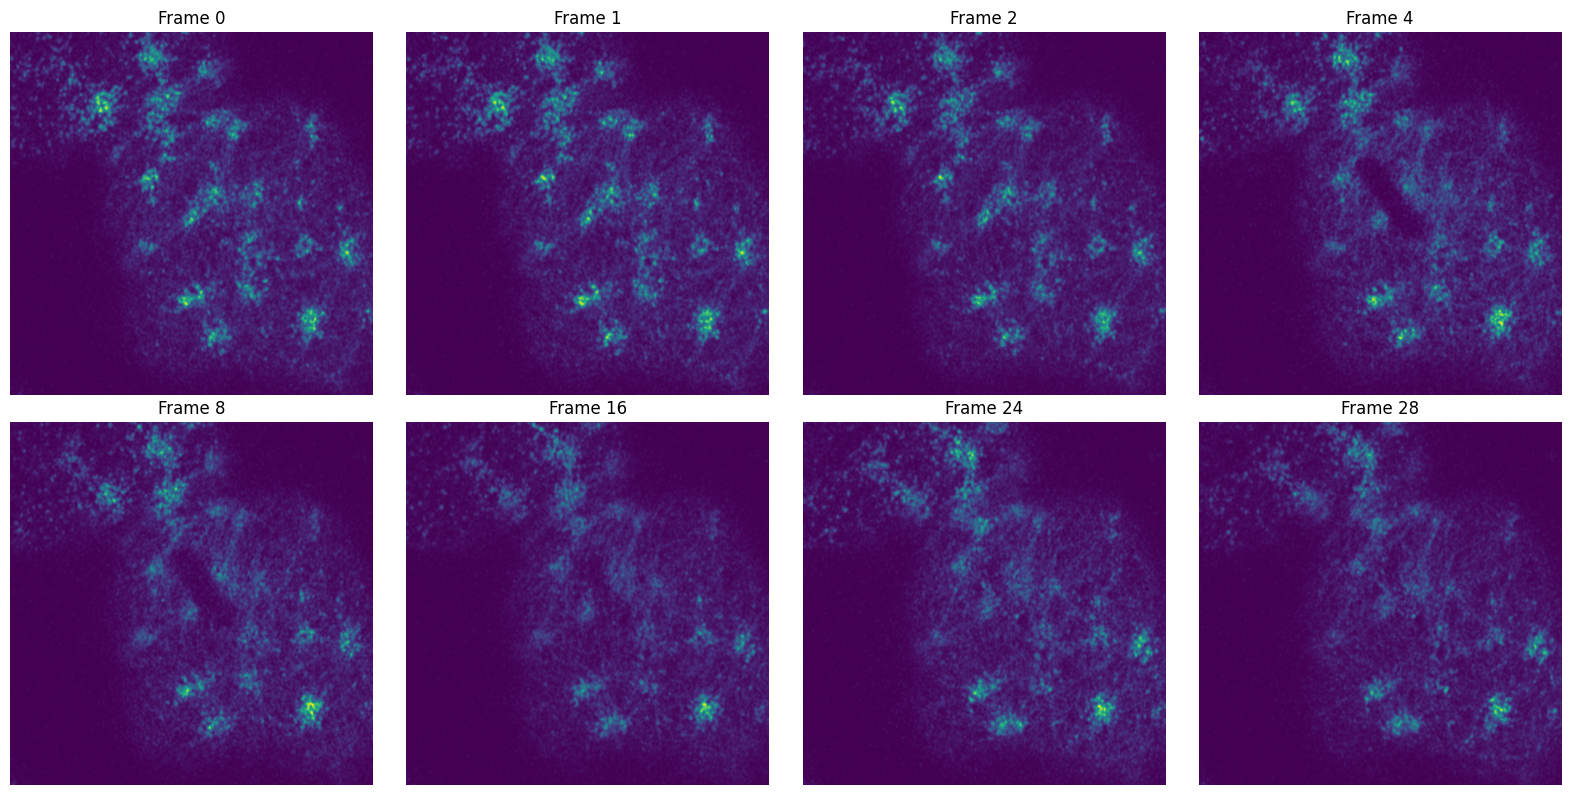

In [903]:
def visualize_frames_grid(rgb_stack: np.ndarray,  frames: list[int], channel: int = 0):
    rgb_stack = rgb_stack[..., channel]
    n_frames = len(frames)
    cols = 4
    rows = (n_frames + cols - 1) // cols  # ceiling division

    fig, axes = plt.subplots(rows, cols, figsize=(4 * cols, 4 * rows))
    axes = np.array(axes).reshape(rows, cols)

    for i, frame_idx in enumerate(frames):
        r, c = divmod(i, cols)
        axes[r, c].imshow(rgb_stack[frame_idx])
        axes[r, c].set_title(f"Frame {frame_idx}")
        axes[r, c].axis('off')

    # Hide any unused subplots
    for j in range(i + 1, rows * cols):
        r, c = divmod(j, cols)
        axes[r, c].axis('off')

    plt.tight_layout()
    plt.show()


visualize_frames_grid(rgb_stack, [0, 1, 2, 4, 8, 16, 24, 28], channel = 0)

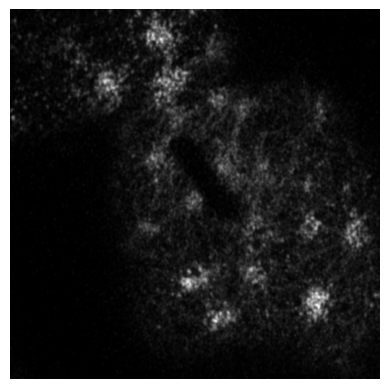

In [904]:
def visualize_frame(rgb_stack: np.ndarray, frame_idx: int, channel: int = 0, cmap: str = 'viridis', ax=None):

    frame = rgb_stack[frame_idx, :, :, channel]

    if ax is None:
        fig, ax = plt.subplots()

    im = ax.imshow(frame, cmap=cmap)
    #ax.set_title(f"Frame {frame_idx} | {cmap}")
    ax.axis('off')
    return ax

img = visualize_frame(rgb_stack, 4, cmap='gray')
plt.show()

## Visualize cut

x1: 311.0, y1: 278.0, x2: 239.0, y2: 189.0


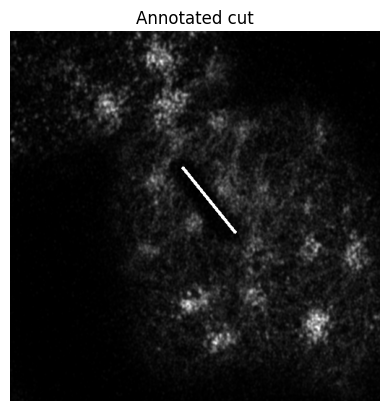

In [905]:
### --- Get points for experiment --- ###

cell_id_to_keep = experiment

# Load the data
points_file_loc = f"../../data/ablation-lineage/{cell_id_to_keep}.lineage"
df = pd.read_csv(points_file_loc, sep='\t')

df.head()

# Extract cuts
df_cuts = df[df.iloc[:, 0].str.contains("cut", case=False, na=False)]

df_cuts.head()


### --- Draw cut line --- ###

# Extract the points for the cuts (first two rows in this case)
x1, y1 = df_cuts.iloc[0]['x'], df_cuts.iloc[0]['y']
x2, y2 = df_cuts.iloc[1]['x'], df_cuts.iloc[1]['y']

print(f"x1: {x1}, y1: {y1}, x2: {x2}, y2: {y2}")

p1 = x1, y1
p2 = x2, y2
p1 = (int(p1[0]), int(p1[1]))
p2 = (int(p2[0]), int(p2[1]))

img = rgb_stack[4, :, :, 0]
img_norm = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

img_norm = cv2.line(img_norm, tuple(p1), tuple(p2), (255, 0, 0), 3)

plt.imshow(img_norm, cmap='gray'); plt.title('Annotated cut'); plt.axis('off')

output_path = f"out/annotated_cut_{experiment}.jpg"
plt.savefig(output_path, dpi=300, bbox_inches='tight')

## Dim bright spots

In [906]:
# # Normalize to [0,1]
# #norm = img / 255.0

# # Define brightness threshold
# bright_mask = img > 0.89  # adjust this value (0.7–0.9)

# # Gamma correction for bright areas (gamma > 1 darkens)
# gamma = 2.0
# damped = np.copy(img)
# damped[bright_mask] = np.power(damped[bright_mask], gamma)

# # Rescale back to 0–255
# damped_img = np.uint8(damped * 255)

# # Visualization
# plt.subplot(1,2,1)
# plt.title('Original')
# plt.imshow(img, cmap='gray')

# plt.subplot(1,2,2)
# plt.title('Damped Bright Spots')
# plt.imshow(damped_img, cmap='gray')
# plt.show()

## Blur image

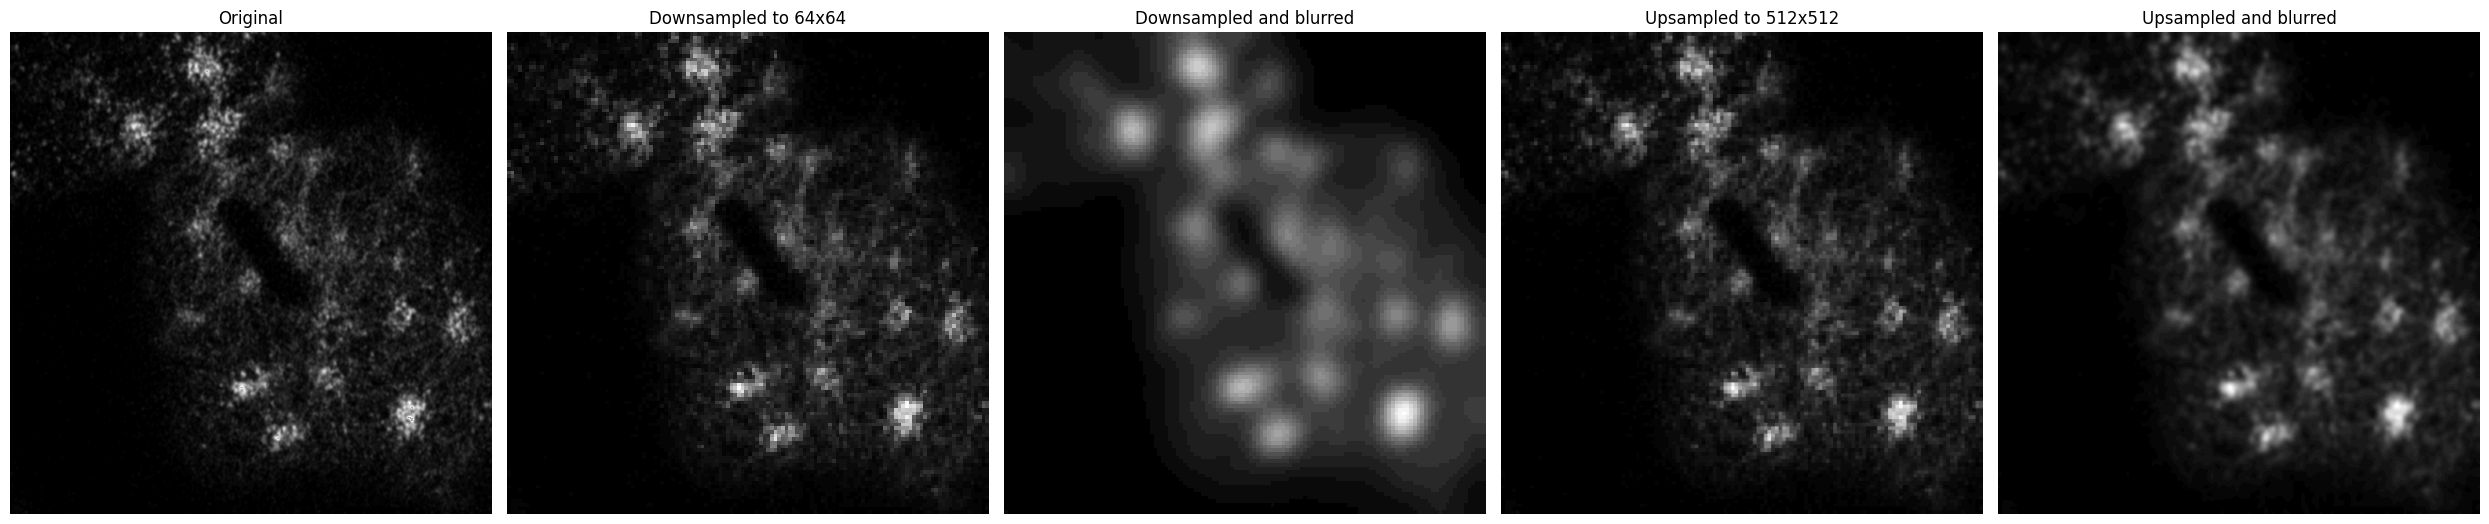

In [907]:
# Downsampling, upsampling, then blur

# img = rgb_stack[4, :, :, 0] # first col is frame

img = damped_img

interpolation_method = cv2.INTER_AREA # cv2.INTER_CUBIC, cv2.INTER_LINEAR, cv2.INTER_NEAREST

downsampled = cv2.resize(img, (132, 132), interpolation=interpolation_method)
upsampled = cv2.resize(downsampled, (512, 512), interpolation=interpolation_method)
downsampled_blurred = cv2.GaussianBlur(downsampled, (31,31), 3)
upsampled_blurred = cv2.GaussianBlur(upsampled, (31,31), 2)

plt.figure(figsize=(25,6))
plt.subplot(1,5,1); plt.imshow(img, cmap='gray'); plt.title('Original'); plt.axis('off')
plt.subplot(1,5,2); plt.imshow(downsampled, cmap='gray'); plt.title('Downsampled to 64x64'); plt.axis('off')
plt.subplot(1,5,3); plt.imshow(downsampled_blurred, cmap='gray'); plt.title('Downsampled and blurred'); plt.axis('off')
plt.subplot(1,5,4); plt.imshow(upsampled, cmap='gray'); plt.title('Upsampled to 512x512'); plt.axis('off')
plt.subplot(1,5,5); plt.imshow(upsampled_blurred, cmap='gray'); plt.title('Upsampled and blurred'); plt.axis('off')
plt.tight_layout()
plt.show()

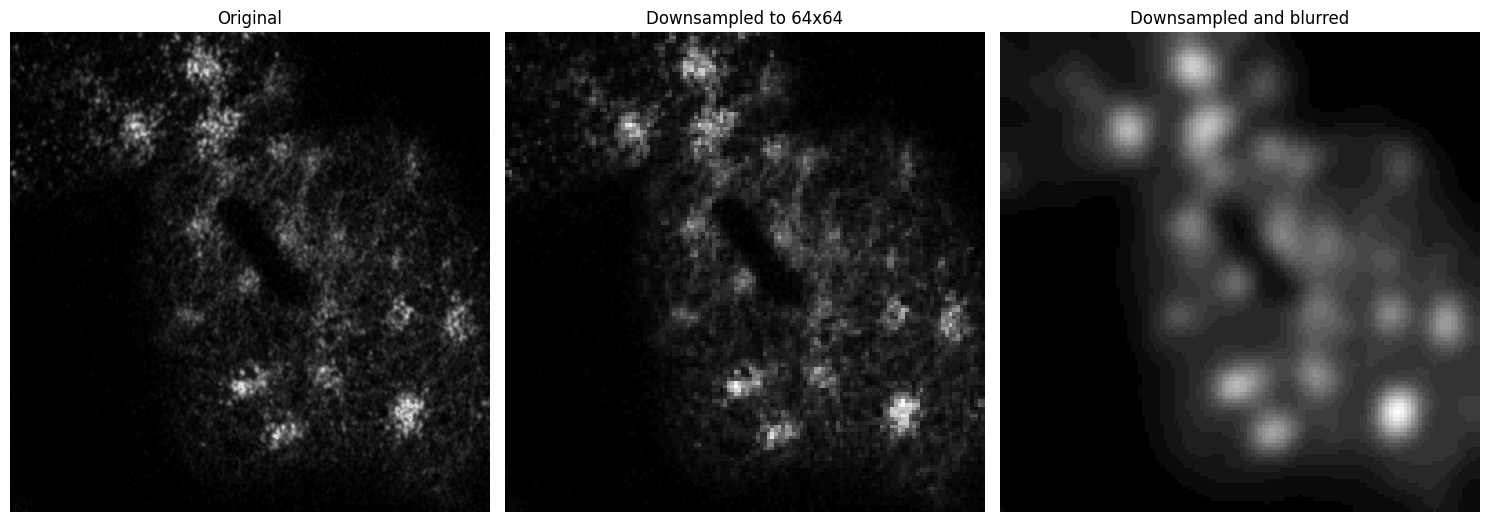

In [908]:
# Save fig
plt.figure(figsize=(15,6))
plt.subplot(1,3,1); plt.imshow(img, cmap='gray'); plt.title('Original'); plt.axis('off')
plt.subplot(1,3,2); plt.imshow(downsampled, cmap='gray'); plt.title('Downsampled to 64x64'); plt.axis('off')
plt.subplot(1,3,3); plt.imshow(downsampled_blurred, cmap='gray'); plt.title('Downsampled and blurred'); plt.axis('off')
plt.tight_layout()

output_path = f"out/downsampled_blurred_{experiment}.jpg"
plt.savefig(output_path, dpi=300, bbox_inches='tight')

## Reduce bright spots, make BW with threshold

(np.float64(-0.5), np.float64(511.5), np.float64(511.5), np.float64(-0.5))

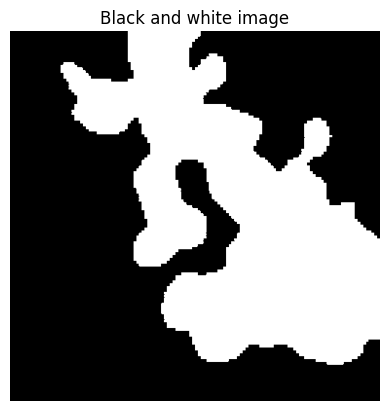

In [909]:
# Threshold
img_bw = cv2.resize(downsampled_blurred, (512, 512), interpolation=interpolation_method)

# img_bw = damped_img

# # Convert to float and normalize (0–1)
#img_float = img_bw.astype(np.float32) / 255.0

# Normalize so the range is 0-255 and convert to 8-bit unsigned integer
img_norm = cv2.normalize(img_bw, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

# Apply Otsu’s threshold
_, img_bin = cv2.threshold(img_norm, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

plt.imshow(img_bin, cmap='gray'); plt.title('Black and white image'); plt.axis('off')



## Find cell and inner cut edges

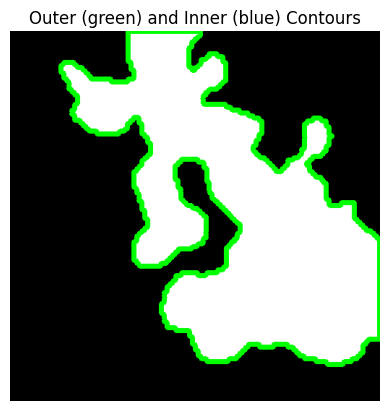

In [910]:
img_bw = cv2.resize(img_bin, (512, 512), interpolation=interpolation_method)

contours, hierarchy = cv2.findContours(img_bw, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)

# Draw results for visualization
result = cv2.cvtColor(img_bw, cv2.COLOR_GRAY2BGR)

# hierarchy[0][i][3] == -1 → outer contour
# hierarchy[0][i][3] != -1 → hole (inner contour)
for i, h in enumerate(hierarchy[0]):
    if h[3] == -1:
        color = (0, 255, 0)  # green for outer
    else:
        color = (0, 0, 255)  # blue for inner
    cv2.drawContours(result, contours, i, color, 5)

# Show result
plt.imshow(result)
plt.title("Outer (green) and Inner (blue) Contours")
plt.axis("off")
plt.show()



Discard other recognized cuts if there were ones, try to find biggest one (hopefully correct one)

No inner hole found


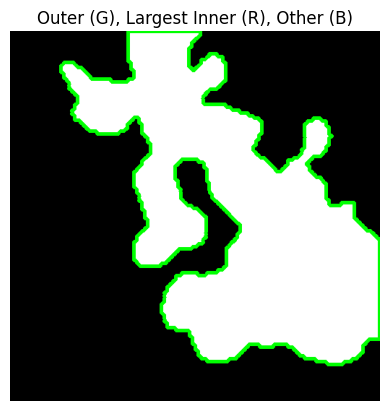

In [911]:
# Convert to color for visualization
result_hole = cv2.cvtColor(img_bw, cv2.COLOR_GRAY2BGR)

largest_inner_idx = None
largest_inner_area = 0

# Loop over contours and find the largest inner one
for i, h in enumerate(hierarchy[0]):
    if h[3] != -1:  # inner contour (hole)
        area = cv2.contourArea(contours[i])
        if area > largest_inner_area:
            largest_inner_area = area
            largest_inner_idx = i

# Draw all contours (outer = green, inner = blue)
for i, h in enumerate(hierarchy[0]):
    color = (0, 255, 0) if h[3] == -1 else (0, 0, 255)
    cv2.drawContours(result_hole, contours, i, color, 3)

# Highlight the largest inner contour (the “main hole”) in a special color
if largest_inner_idx is not None:
    cv2.drawContours(result_hole, contours, largest_inner_idx, (255, 0, 0), 5)  # red outline
    main_hole_contour = contours[largest_inner_idx]
else:
    main_hole_contour = None
    print("No inner hole found")

# Visualize
plt.imshow(result_hole)
plt.title("Outer (G), Largest Inner (R), Other (B)")
plt.axis("off")
plt.show()


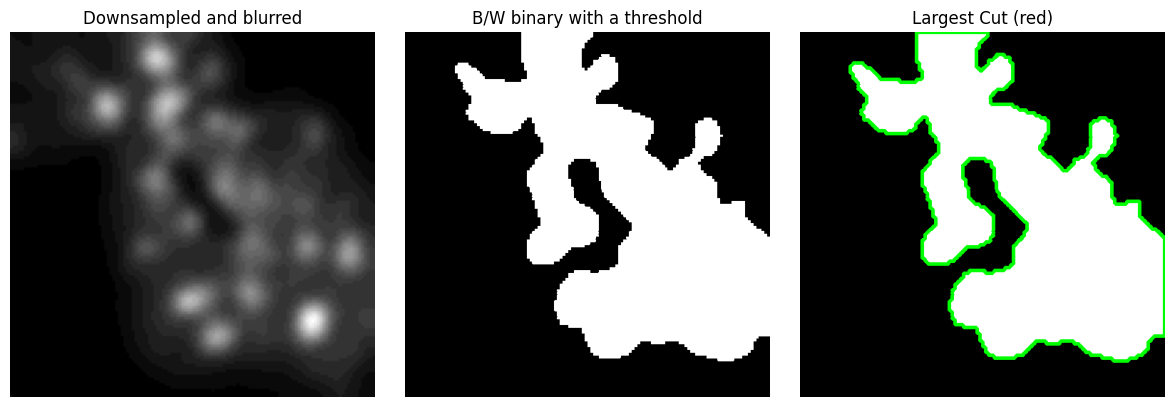

In [912]:
# Save some figures 

plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.imshow(downsampled_blurred, cmap='gray'); plt.title(f"Downsampled and blurred"); plt.axis('off')
plt.subplot(1,3,2); plt.imshow(img_bin, cmap='gray'); plt.title(f"B/W binary with a threshold"); plt.axis('off')
plt.subplot(1,3,3); plt.imshow(result_hole, cmap='gray'); plt.title("Largest Cut (red)"); plt.axis('off')
plt.tight_layout()

output_path = f"out/check_outline_{experiment}.jpg"

plt.savefig(output_path, dpi=300, bbox_inches='tight')

Find the points within the cut that are furthest away from each other

In [913]:
# Extract inner contour (hole)
inner_contour = None
for i, h in enumerate(hierarchy[0]):
    if h[3] != -1:  # has a parent → inner contour
        inner_contour = contours[i]
        break

# Convert to 2D array of points
pts = inner_contour[:, 0, :]  # shape (N, 2)

# Exact method (brute force, fine for small contours) ---
max_dist = 0
p1, p2 = None, None

for i, j in combinations(range(len(pts)), 2):
    dist = np.linalg.norm(pts[i] - pts[j])
    if dist > max_dist:
        max_dist = dist
        p1, p2 = pts[i], pts[j]

# Draw results
result = cv2.cvtColor(img_bw, cv2.COLOR_GRAY2BGR)
cv2.drawContours(result, [inner_contour], -1, (0, 255, 0), 3)  # inner contour
cv2.line(result, tuple(p1), tuple(p2), (0, 255, 255), 3)
cv2.circle(result, tuple(p1), 4, (0, 100, 255), -1)
cv2.circle(result, tuple(p2), 4, (0, 100, 255), -1)

plt.imshow(result); plt.title("Farthest Points in Inner Cut"); plt.axis("off")
plt.show()


TypeError: 'NoneType' object is not subscriptable

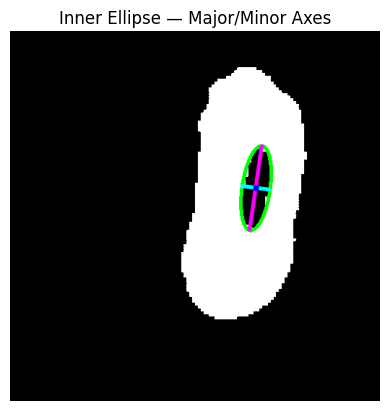

Center: (340.08, 217.08)
Major axis length: 118.09
Minor axis length: 38.87
Orientation angle: 8.13°
Major axis endpoints: (348, 158), (331, 275)
Minor axis endpoints: (320, 214), (359, 219)


In [ ]:
# Fit ellipse
ellipse = cv2.fitEllipse(inner_contour)
(center, axes, angle) = ellipse
(xc, yc) = center
(minor, major) = axes
angle_rad = np.deg2rad(angle)

# Compute minor-axis endpoints
x_minor = (minor / 2) * np.cos(angle_rad)
y_minor = (minor / 2) * np.sin(angle_rad)
pt1_minor = (int(xc - x_minor), int(yc - y_minor))
pt2_minor = (int(xc + x_minor), int(yc + y_minor))

# Compute major-axis endpoints 
x_major = (major / 2) * np.cos(angle_rad + np.pi / 2)
y_major = (major / 2) * np.sin(angle_rad + np.pi / 2)
pt1_major = (int(xc - x_major), int(yc - y_major))
pt2_major = (int(xc + x_major), int(yc + y_major))

# Draw everything
result2 = cv2.cvtColor(img_bw, cv2.COLOR_GRAY2BGR)
cv2.ellipse(result2, ellipse, (0, 255, 0), 3)                                     # ellipse
cv2.line(result2, pt1_minor, pt2_minor, (0, 255, 255), 3, lineType=cv2.LINE_AA)   # minor axis (yellow)
cv2.line(result2, pt1_major, pt2_major, (255, 0, 255), 3, lineType=cv2.LINE_AA)   # major axis (magenta)
cv2.circle(result2, (int(xc), int(yc)), 4, (0, 0, 255), -1)                       # center

# Display
plt.imshow(result2)
plt.title("Inner Ellipse — Major/Minor Axes")
plt.axis("off")
plt.show()

# Print numeric info
print(f"Center: ({xc:.2f}, {yc:.2f})")
print(f"Major axis length: {major:.2f}")
print(f"Minor axis length: {minor:.2f}")
print(f"Orientation angle: {angle:.2f}°")
print(f"Major axis endpoints: {pt1_major}, {pt2_major}")
print(f"Minor axis endpoints: {pt1_minor}, {pt2_minor}")


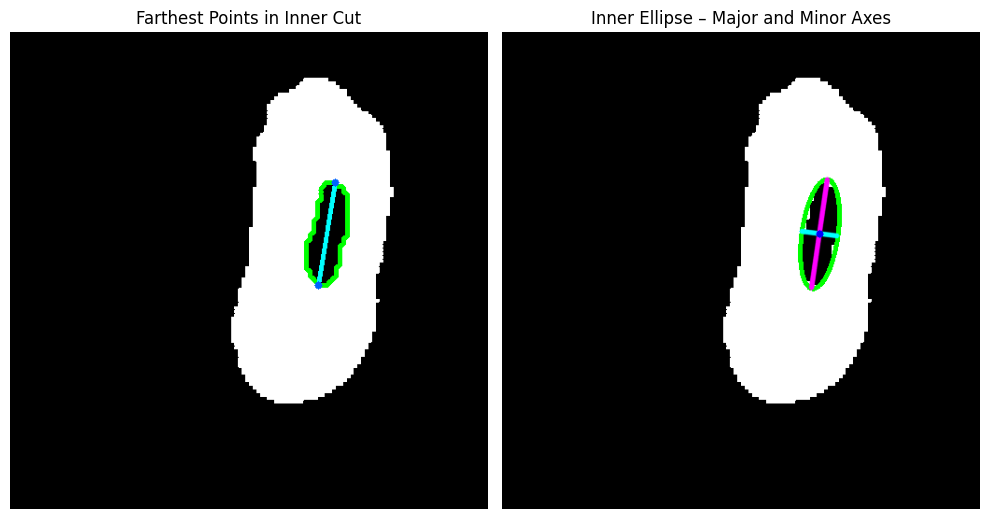

In [ ]:
# Save two figures

plt.figure(figsize=(10,6))
plt.subplot(1,2,1); plt.imshow(result, cmap='gray'); plt.title("Farthest Points in Inner Cut"); plt.axis('off')
plt.subplot(1,2,2); plt.imshow(result2, cmap='gray'); plt.title("Inner Ellipse – Major and Minor Axes"); plt.axis('off')
plt.tight_layout()

output_path = f"out/edges_and_ellipses_{experiment}.jpg"

plt.savefig(output_path, dpi=300, bbox_inches='tight')

## Draw parallell and perpendicular lines

Center: (340.08, 217.08)
Orientation angle: 8.13°
Major axis endpoints: (348, 158), (331, 275)


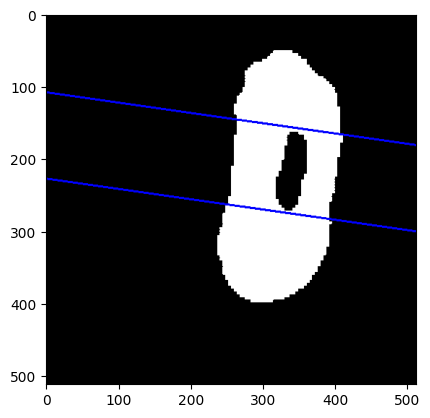

In [ ]:
print(f"Center: ({xc:.2f}, {yc:.2f})")
print(f"Orientation angle: {angle:.2f}°")
print(f"Major axis endpoints: {pt1_major}, {pt2_major}")

# Start fresh each time
img_perp = cv2.cvtColor(img_bin, cv2.COLOR_GRAY2BGR)

# Compute perpendicular angle
perp_angle = angle
theta = np.deg2rad(perp_angle)
dx, dy = np.cos(theta), np.sin(theta)

# Extend the perpendicular lines to cross the whole image
h, w = img_perp.shape[:2]
L = max(h, w) * 2

# For each major axis endpoint, draw a perpendicular line
for pt in [pt1_major, pt2_major]:
    x0, y0 = pt
    pt1 = (int(x0 - L * dx), int(y0 - L * dy))
    pt2 = (int(x0 + L * dx), int(y0 + L * dy))
    cv2.line(img_perp, pt1, pt2, (0, 0, 255), 2)

plt.imshow(img_perp)

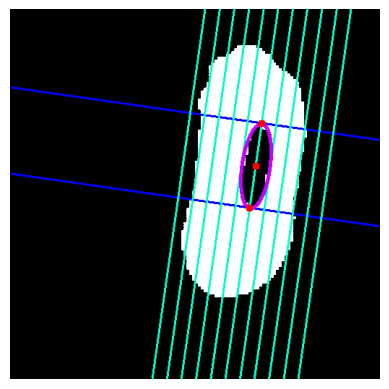

In [ ]:
# Compute parallel direction
par_angle = angle + 90
theta = np.deg2rad(par_angle)
dx, dy = np.cos(theta), np.sin(theta)
L = max(img_bin.shape[:2]) * 2

# Draw ellipse edge points
cv2.circle(img_perp, (int(pt1_major[0]), int(pt1_major[1])), 4, (255, 0, 0), -1)
cv2.circle(img_perp, (int(pt2_major[0]), int(pt2_major[1])), 4, (255, 0, 0), -1)

# Add ellipse edge perpendicular lines
cv2.line(img_perp, pt1_major, pt2_major, (0, 122, 0), 2)

# Draw multiple parallel lines through the center
num_lines = 10
spacing = 20

dir_vec = np.array([np.cos(np.deg2rad(angle)), np.sin(np.deg2rad(angle))])

for i in range(-num_lines//2, num_lines//2 + 1):
    offset = i * spacing
    cx = xc + offset * dir_vec[0]
    cy = yc + offset * dir_vec[1]

    pt1 = (int(cx - L * dx), int(cy - L * dy))
    pt2 = (int(cx + L * dx), int(cy + L * dy))
    cv2.line(img_perp, pt1, pt2, (0, 255, 200), 2)

# Draw ellipse
cv2.ellipse(img_perp, ellipse, (200, 0, 255), 3) 

# Draw center and edge points
cv2.circle(img_perp, (int(xc), int(yc)), 5, (255, 0, 0), -1)
cv2.circle(img_perp, pt1_major, 5, (255, 0, 0), -1)
cv2.circle(img_perp, pt2_major, 5, (255, 0, 0), -1)

# Show
plt.imshow(img_perp)
plt.axis('off')

output_path = f"out/lines_{experiment}.jpg"

plt.savefig(output_path, dpi=300, bbox_inches='tight')



In [ ]:
def draw_perp_and_par_lines(image, centerpoint: tuple, point1: tuple, point2: tuple, angle: float):

    # Unpack center coordinates
    xc, yc = centerpoint

    # --- Perpendicular lines ---
    perp_angle = angle
    theta = np.deg2rad(perp_angle)
    dx, dy = np.cos(theta), np.sin(theta)

    # Extend lines to cross the whole image
    h, w = image.shape[:2]
    L = max(h, w) * 2

    # Draw perpendicular lines through both major-axis points
    for pt in [point1, point2]:
        x0, y0 = pt
        pt1 = (int(x0 - L * dx), int(y0 - L * dy))
        pt2 = (int(x0 + L * dx), int(y0 + L * dy))
        cv2.line(image, pt1, pt2, (0, 0, 255), 2)

    # --- Parallel lines ---
    par_angle = angle + 90
    theta = np.deg2rad(par_angle)
    dx, dy = np.cos(theta), np.sin(theta)

    # Draw the major axis (point1 ↔ point2)
    cv2.line(image, point1, point2, (0, 122, 0), 2)

    # Draw multiple parallel lines through the center
    num_lines = 10
    spacing = 20
    dir_vec = np.array([np.cos(np.deg2rad(angle)), np.sin(np.deg2rad(angle))])

    for i in range(-num_lines // 2, num_lines // 2 + 1):
        offset = i * spacing
        cx = xc + offset * dir_vec[0]
        cy = yc + offset * dir_vec[1]

        pt1 = (int(cx - L * dx), int(cy - L * dy))
        pt2 = (int(cx + L * dx), int(cy + L * dy))
        cv2.line(image, pt1, pt2, (0, 255, 0), 2) 

    # --- Draw ellipse --- #
    cv2.ellipse(image, ellipse, (255, 0, 255), 3)      

    # --- Draw points --- #
    cv2.circle(image, (int(xc), int(yc)), 4, (255, 0, 0), -1)  # center
    cv2.circle(image, (int(point1[0]), int(point1[1])), 4, (255, 0, 0), -1)
    cv2.circle(image, (int(point2[0]), int(point2[1])), 4, (255, 0, 0), -1)

    # --- Show result --- #
    plt.imshow(image,cmap='gray',vmin=0,vmax=255); plt.axis('off')
    plt.show()


Center: (340.08, 217.08)
Orientation angle: 8.13°
Major axis endpoints: (348, 158), (331, 275)


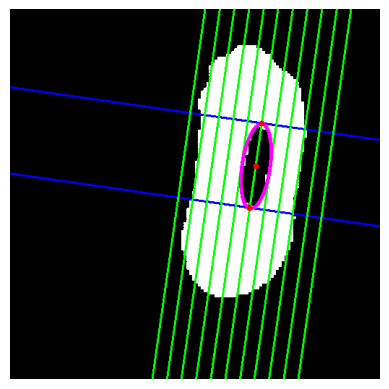

In [ ]:
print(f"Center: ({xc:.2f}, {yc:.2f})")
print(f"Orientation angle: {angle:.2f}°")
print(f"Major axis endpoints: {pt1_major}, {pt2_major}")


# Start fresh each time
img_perp = cv2.cvtColor(img_bin, cv2.COLOR_GRAY2BGR)


draw_perp_and_par_lines(img_perp, (xc, yc), (pt1_major), (pt2_major), angle)



## Non-filtered

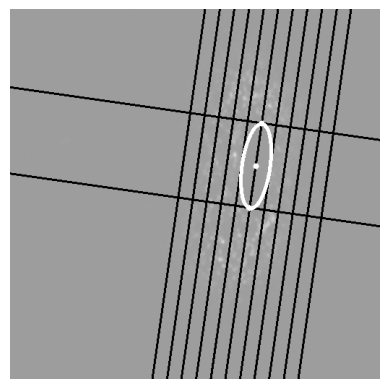

In [ ]:
# Downsampling, upsampling, then blur

img = rgb_stack[4, :, :, 0] # first col is frame

img0 = cv2.resize(img, (512, 512), interpolation=cv2.INTER_AREA) * 255

draw_perp_and_par_lines(img0, (xc, yc), (pt1_major), (pt2_major), angle)
